In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from deepeval import evaluate
from deepeval.evaluate import DisplayConfig, AsyncConfig
display_config = DisplayConfig(
    show_indicator=True,
    print_results=False,
    verbose_mode=False,
)
async_config = AsyncConfig(
    max_concurrent=20
)
import toml
with open('config.toml', 'r', encoding='utf-8') as toml_file:
    config = toml.load(toml_file)

model_names = config['model_names']
alter_names = model_names.copy() # Create a copy to modify

for i, name in enumerate(alter_names):
    if name in config['alternative_names']: 
        alter_names[i] = config['alternative_names'][name]

for name in alter_names:
    print(name)
INPUT_EXCEL_FILE = "goldens" / Path(config['QA_file_name'])
question_dfs = pd.read_excel(INPUT_EXCEL_FILE, sheet_name=None, index_col=0)
DOMAIN = list(question_dfs.keys())
num_questions_per_domain = question_dfs[DOMAIN[0]].shape[0]
print(f"共有{len(DOMAIN)}个领域，每个领域有{num_questions_per_domain}个问题")

QA_df = {}
for i, model in enumerate(model_names):
    QA_FILE = "QA" / Path(f"{model}_answers.xlsx")
    QA_df[model_names[i]] = pd.read_excel(QA_FILE, sheet_name=None, index_col=0)
from custom_metrics import get_dataset, correctness_metric, relevance_metric
from deepeval import evaluate
from deepeval.dataset import EvaluationDataset

DeepSeek-R1-Distill-Qwen-32B
DeepSeek-R1-Distill-Qwen-14B
deepseek/deepseek-r1
openai/gpt-4.1
openai/o3
anthropic/claude-sonnet-4
google/gemini-2.5-pro-preview
x-ai/grok-3-beta
共有13个领域，每个领域有10个问题


In [2]:
inference_model = model_names[1]
reference_answer = model_names[6]
case_dataset = get_dataset(
        infer_model=inference_model,
        ref_model=reference_answer,
        question_dataframe=question_dfs,
        QA_dataframe=QA_df,
        domains=DOMAIN
    )
evaluation_output = evaluate(case_dataset, 
                             [correctness_metric], 
                             display_config=display_config,
                             async_config=async_config,
                             )

✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |█         | 11% (14/130) [Time Taken: 12:02, 51.64s/test case]


APITimeoutError: Request timed out.

In [ ]:
evaluation_output.test_results[0].__dict__

{'name': 'test_case_7',
 'success': True,
 'metrics_data': [MetricData(name='正确率 (GEval)', threshold=0.5, success=True, score=0.7, reason='实际输出核心结论与预期一致，但缺少对反常输运机制的具体描述（如玻姆扩散公式中缺少系数和单位，近壁电导未提及湍流影响），且未明确比较经典与反常输运模型。', strict_mode=False, evaluation_model='deepseek-r1 (JSON)', error=None, evaluation_cost=None, verbose_logs='Criteria:\nNone \n \nEvaluation Steps:\n[\n    "用简体中文陈述给分原因",\n    "检查最终结论是否与预期中的结论一致",\n    "推导思路相近但结论不同的情况，认为是错误的",\n    "如果出现公式和物理量，需要检查代表内容是否一致"\n] \n \nRubric:\nNone')],
 'conversational': False,
 'multimodal': False,
 'input': '讨论E×B漂移在等离子体约束和输运中的双重作用。以霍尔推进器或磁控溅射为例，分析闭合E×B漂移系统中的反常电子输运机制（如玻姆扩散、近壁电导）。',
 'actual_output': '**E×B漂移的双重作用及其在霍尔推进器和磁控溅射中的应用**\n\n**1. 核心结论**\n\nE×B漂移在等离子体约束中起到关键作用，但在闭合系统中可能导致玻姆扩散和近壁电导等反常电子输运，影响装置性能。\n\n**2. 背景与概念**\n\nE×B漂移是指等离子体中带电粒子在电场(E)和磁场(B)共同作用下的漂移运动。在托卡马克等装置中，强磁场约束等离子体，抑制垂直输运。然而，闭合的E×B路径可能引发反常输运，如玻姆扩散和近壁电导。\n\n**3. 原理与机理分析**\n\n- **约束作用**：E×B漂移方向与磁场垂直，有效限制等离子体运动，防止逸出。\n- **输运作用**：闭合路径形成环流，导致玻姆扩散和近壁电导，影响输运效率。\n\n**4. 定量估算与示例**\n\n- 

In [ ]:
evaluation_output.test_results[0].metrics_data[0].__dict__

{'name': '正确率 (GEval)',
 'threshold': 0.5,
 'success': True,
 'score': 0.7,
 'reason': '实际输出核心结论与预期一致，但缺少对反常输运机制的具体描述（如玻姆扩散公式中缺少系数和单位，近壁电导未提及湍流影响），且未明确比较经典与反常输运模型。',
 'strict_mode': False,
 'evaluation_model': 'deepseek-r1 (JSON)',
 'error': None,
 'evaluation_cost': None,
 'verbose_logs': 'Criteria:\nNone \n \nEvaluation Steps:\n[\n    "用简体中文陈述给分原因",\n    "检查最终结论是否与预期中的结论一致",\n    "推导思路相近但结论不同的情况，认为是错误的",\n    "如果出现公式和物理量，需要检查代表内容是否一致"\n] \n \nRubric:\nNone'}

In [ ]:
evaluation_output_df = pd.DataFrame(
    [
        {
            "input": evaluation_output.test_results[i].input,
            "actual_output": evaluation_output.test_results[i].input,
            "expected_output": evaluation_output.test_results[i].expected_output,
            "score": evaluation_output.test_results[i].metrics_data[0].score,
            "reason": evaluation_output.test_results[i].metrics_data[0].reason,
        } 
    for i in range(len(evaluation_output.test_results))
    ])
evaluation_output_df.to_parquet("evaluation_output.parquet")

In [6]:
evaluation_output_df.head()

,input,actual_output,expected_output,score,reason
0,讨论E×B漂移在等离子体约束和输运中的双重作用。以霍尔推进器或磁控溅射为例，分析闭合E×B漂...,讨论E×B漂移在等离子体约束和输运中的双重作用。以霍尔推进器或磁控溅射为例，分析闭合E×B漂...,### 核心结论\n\[ \mathbf{E} \times \mathbf{B} \] 漂...,0.7,实际输出核心结论与预期一致，但缺少对反常输运机制的具体描述（如玻姆扩散公式中缺少系数和单位，...
1,如何通过实验手段测量等离子体的基本参数，如电子温度（Te​）、离子温度（Ti​）、电子密度（...,如何通过实验手段测量等离子体的基本参数，如电子温度（Te​）、离子温度（Ti​）、电子密度（...,1. **核心结论** \n 等离子体的基本参数如电子温度、离子温度、电子密度和等离子...,0.6,实际输出包含光谱诊断、干涉仪/极光仪、微波诊断和磁诊断，但预期输出要求汤姆逊散射诊断、干涉仪...
2,在托卡马克先进运行模式中，如何通过优化电流密度剖面和压强剖面来提高MHD稳定性极限，例如避免...,在托卡马克先进运行模式中，如何通过优化电流密度剖面和压强剖面来提高MHD稳定性极限，例如避免...,1. **核心结论** —— 通过优化电流密度剖面和压强剖面，可以提升托卡马克装置的MHD稳...,0.9,实际输出与预期输出的核心结论一致，均强调优化电流密度和压强剖面可提升MHD稳定性并抑制NTM...
3,解释Mercier判据和气球模判据在仿星器局部稳定性评估中的应用。为何在仿星器中，即使局部判...,解释Mercier判据和气球模判据在仿星器局部稳定性评估中的应用。为何在仿星器中，即使局部判...,### 核心结论\nMercier判据和气球模判据用于评估仿星器中的局部等离子体稳定性，但即...,0.6,核心结论一致，但Mercier判据公式（涉及∇p·∇ψ）与预期（含q²β_p）不符，气球模判...
4,解释理想MHD中的主要不稳定性模式，如扭曲模（Kink modes）和气球模（Balloon...,解释理想MHD中的主要不稳定性模式，如扭曲模（Kink modes）和气球模（Balloon...,### 核心结论\n理想MHD中的扭曲模和气球模是两种主要的不稳定性模式，分别由等离子体的电...,0.3,实际输出中扭曲模的驱动机制被错误描述为纵向压强梯度（预期应为电流），气球模的驱动机制正确但整...


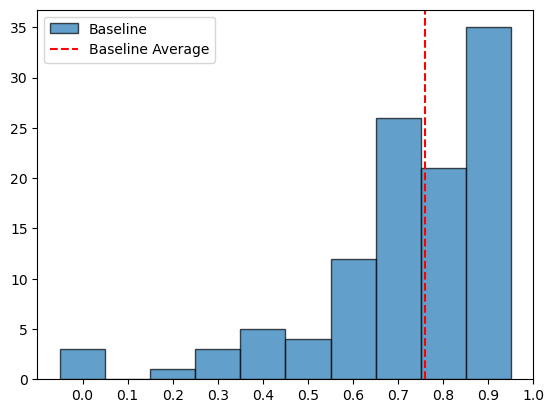

In [7]:
from matplotlib import pyplot as plt
scores = evaluation_output_df['score'].tolist()
average_score = np.mean(scores)
bin_edges = np.arange(-0.05, 1.05, 0.1)
plt.hist(scores, bins=bin_edges, label='Baseline', edgecolor='black', alpha=0.7)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.axvline(average_score, color='r', linestyle='--', label='Baseline Average')
plt.legend()
plt.show()

In [ ]:
trained_inference_model = model_names[2]
reference_answer = model_names[6]
case_dataset = get_dataset(
        infer_model=trained_inference_model,
        ref_model=reference_answer,
        question_dataframe=question_dfs,
        QA_dataframe=QA_df,
        domains=DOMAIN
    )
trained_evaluation_output = evaluate(case_dataset, 
                             [correctness_metric], 
                             display_config=display_config,
                            #  hyperparameters={"Temperature": 0.1, "Max Tokens": 50000, "System Prompt": "You MUST NOT add any extra commentary outside the JSON"}
                             )

✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 15:37,  7.21s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

In [11]:
trained_evaluation_output_df = pd.DataFrame(
    [
        {
            "input": trained_evaluation_output.test_results[i].input,
            "actual_output": trained_evaluation_output.test_results[i].input,
            "expected_output": trained_evaluation_output.test_results[i].expected_output,
            "score": trained_evaluation_output.test_results[i].metrics_data[0].score,
            "reason": trained_evaluation_output.test_results[i].metrics_data[0].reason,
        } 
    for i in range(len(trained_evaluation_output.test_results))
    ])
trained_evaluation_output_df.to_parquet("trained_evaluation_output_df.parquet")

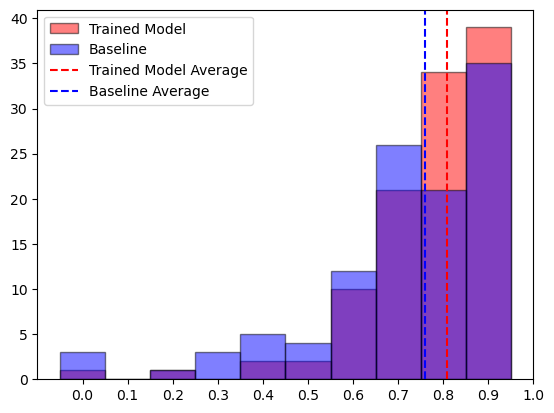

In [10]:
trained_scores = trained_evaluation_output_df['score'].tolist()
trained_average_score = np.mean(trained_scores)
bin_edges = np.arange(-0.05, 1.05, 0.1)
plt.hist(trained_scores, bins=bin_edges, label='Trained Model', edgecolor='black', alpha=0.5, color='r')
plt.hist(scores, bins=bin_edges, label='Baseline', edgecolor='black', alpha=0.5, color='b')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.axvline(trained_average_score, color='r', linestyle='--', label='Trained Model Average')
plt.axvline(average_score, color='b', linestyle='--', label='Baseline Average')
plt.legend()
plt.show()